In [1]:
import numpy as np
import scipy as sp
from   matplotlib import pyplot as plt
from   matplotlib.patches import Rectangle
from   matplotlib         import gridspec, rc
from   matplotlib.colors  import LinearSegmentedColormap
import matplotlib.patheffects as pe

from   matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn            as sns
import mplhep             as hep
import my_cmaps           #kViridis, parula, jets
plt.style.use("default")
#plt.style.use(hep.style.ATLAS)
verb = FontProperties()
verb.set_family("monospace")

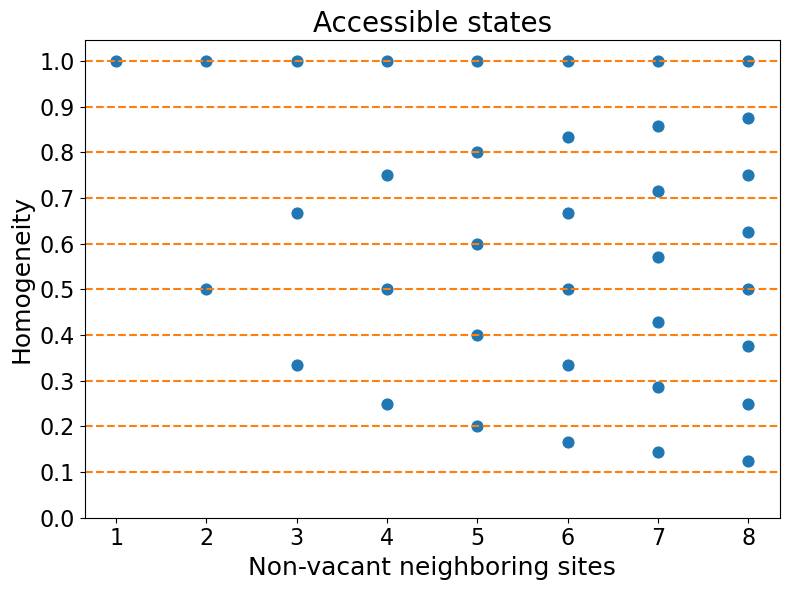

In [104]:
a = []
b = []
fig = plt.figure(figsize=(8,6))
for i in range(1,9):
    for j in range(1,i+1):
        b.append(i)
        a.append(j/i)
        
for i in range(1,11):
    plt.axhline(i/10, ls='dashed', c='C1')
plt.scatter(b,a,s=60)
plt.yticks(np.linspace(0,1,11))
plt.title("Accessible states",fontsize=20)
plt.ylabel("Homogeneity",fontsize=18)
plt.xlabel("Non-vacant neighboring sites",fontsize=18)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("states.pdf")
plt.show()

In [2]:
class lattice:
    def __init__(self, size, vac):
        self.N = size
        self.rho = vac
        self.grid = np.random.choice([-1,0,1],size=(self.N,self.N),p=[(1-self.rho)/2,self.rho,(1-self.rho)/2])
        self.jx, self.iy = np.meshgrid(np.arange(self.N),np.arange(self.N),indexing = 'xy')
        self.idx = np.stack([self.iy.ravel(),self.jx.ravel()], axis=-1)
    def set_state(self, g):
        self.grid = g.copy()
        
    def vacancies(self):
        # returns the site indices of vacancies
        a = np.abs(self.grid**2 - 1) # i?f |Gij| = 1/0 -set as-> 0/1
        zeros = np.where(a.ravel() == 1, True, False)
        jx = (self.jx*a).ravel()
        iy = (self.iy*a).ravel()
        return np.stack([iy[zeros], jx[zeros]], axis=-1)

    def occupants(self):
        # returns the site indices of occupants
        a = np.abs(self.grid**2) # i?f |Gij| = 1/0 -set as-> 0/1
        ones = np.where(a.ravel() == 1, True, False)
        jx = (self.jx*a).ravel()
        iy = (self.iy*a).ravel()
        return np.stack([iy[ones], jx[ones]], axis = -1)
        
    def swap(self, i0, j0, i1, j1):
        # swap two elements in the grid
        tmp = self.grid[i0,j0]
        self.grid[i0,j0] = self.grid[i1,j1]
        self.grid[i1,j1] = tmp
        return

    def homogeneity(self,sites, swap=False, swap_i=0, swap_j=0):
        # iterate over an array of site indices and calculate the local homogeneity for each site
        sat = np.zeros(len(sites[:,0]))
        pad_grid = np.zeros(shape=(self.N+2,self.N+2))
        pad_grid[0,0] = self.grid[-1,-1]
        pad_grid[-1,-1] = self.grid[0,0]
        pad_grid[0,-1] = self.grid[-1,0]
        pad_grid[-1,0] = self.grid[0,-1]
        pad_grid[1:-1,1:-1] = self.grid
        pad_grid[1:-1,0] = self.grid[::,-1]
        pad_grid[1:-1,-1] = self.grid[::,0]
        pad_grid[0,1:-1] = self.grid[-1,::]
        pad_grid[-1,1:-1] = self.grid[0,::]
        for k,l in enumerate(sites):
            i,j = l[0]+1,l[1]+1
            if swap == False:
                center_val = pad_grid[i,j]
            elif swap == True:
                center_val = self.grid[swap_i, swap_j]
            neighbor = pad_grid[i-1:i+2,j-1:j+2].ravel()*np.array([1,1,1,1,0,1,1,1,1])
            numer = np.sum(np.abs(center_val*neighbor) - center_val*neighbor)
            denom = np.sum(np.abs(center_val*neighbor))*2
            if denom == 0:
                sat[k] = 0
            else:
                sat[k] = numer/denom
        return sat
        
    def energy(self):
        # for plotting energy distribution
        E = self.homogeneity(self.idx, swap=False)
        return E
        
    def interfaces(self):
        # identify boundaries
        hor = np.where((self.grid * np.roll(self.grid,-1,axis=0)).ravel() == -1, True, False).reshape(self.N,self.N)
        ver = np.where((self.grid * np.roll(self.grid,-1,axis=1)).ravel() == -1, True, False).reshape(self.N,self.N)
        h = np.where((self.grid * np.roll(self.grid,-1,axis=0)).ravel() !=  0, True, False)
        v = np.where((self.grid * np.roll(self.grid,-1,axis=1)).ravel() !=  0, True, False)
        return hor, ver, (hor.sum() + ver.sum())/(h.sum()+v.sum())
        
    def lottery_empty(self, vacancies, uniform=True, weights=None):
        # randomly select one vacant spot
        # probabiliy of draft can be adjusted with the weights argument
        N_vacancies = len(vacancies[:,0])
        if uniform == True:
            i = np.random.choice(a=N_vacancies, size=1)
        elif uniform == False:
            i = np.random.choice(a=N_vacancies, size=1, p=weights/np.sum(weights))
        return vacancies[i,0], vacancies[i,1]
        
    def lottery_agent(self, occupants, uniform=True,  weights=None):
        # randomly select one occupant
        # probabiliy of draft can be adjusted with the weights argument
        N_occupants = len(occupants[:,0])
        if uniform == True:
            i = np.random.choice(a=N_occupants, size=1)
        elif uniform == False:
            i = np.random.choice(a=N_occupants, size=1, p=weights/np.sum(weights))
        return occupants[i,0], occupants[i,1]
        
    def distance(self, agent, sites):
        # using index as coordinate to calculate distance
        # typical use case will input vacancies as 'sites'
        # can be used as 'weight' in 'lottery_empty'
        di = sites[:,0] - agent[0]
        dj = sites[:,1] - agent[1]
        return np.sqrt(di**2 + dj**2)
        
    def site_score(self, agent, sites):
        # intended to calculate how desirable a vacancy is to the agent if it was to move in
        # typical use case will input vacancies as 'sites'
        # can be used as 'weight' in 'lottery_empty'
        swap_satis = self.homogeneity(sites, swap=True, site_i=agent[0], site_j=agent[1])
        return swap_satis

    def transition_probability(self, agent, sites):
        # intended to combine distance and site_score to determine desirable relocation
        # typical use case will input vacancies as 'sites'
        # can be used as 'weight' in 'lottery_empty'
        prob = (self.N/self.distance(sites)) * self.site_score(agent, sites)
        return prob

    def satisfaction(self):
        # Schelling
        sites = self.occupants()
        satis = self.homogeneity(sites)
        # assign a value of 1 to sites that do not meet threshold homogeneity
        # higher homogeneity score indicate more opposite type neighbor
        return np.where(satis < fraction, 1, 0)
        # Utility function
    
    def converge(self):
        return self.satisfaction().sum()/len(self.satisfaction())
        

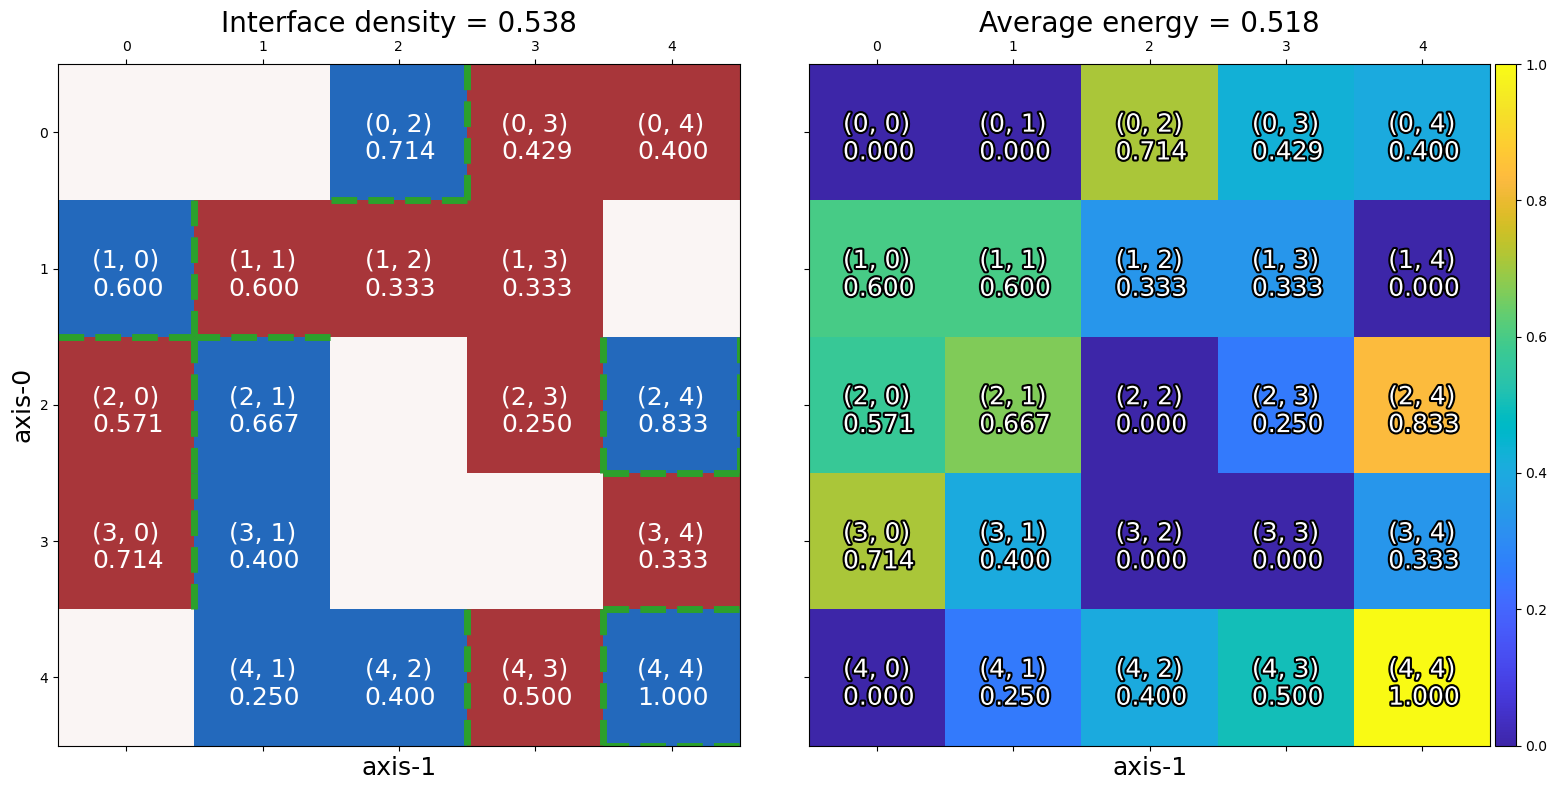

In [96]:

N = 5
rho = 0.1
P = lattice(N, rho)
fraction = 0.5
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(17,8), sharey='row', tight_layout=True)
ax[0].matshow(P.grid, cmap=sns.color_palette("vlag", as_cmap=True))
#'''
#ax[0].scatter(P.vacancies()[:,1], P.vacancies()[:,0], facecolor = 'None', edgecolor = 'k')
#ax[0].scatter(P.occupants()[:,1], P.occupants()[:,0], facecolor = 'w'   , edgecolor = 'k')
for i, vac in enumerate(P.occupants()):
    ax[0].text(vac[1]-0.25,vac[0]+0.2,f"{(vac[0],vac[1])}\n{P.homogeneity(P.occupants())[i]:.3f}",c='w',fontsize=18)
    
for i, idx in enumerate(P.idx):
     ax[1].text(idx[1]-0.25,idx[0]+0.2,f"{(idx[0],idx[1])}\n{P.energy()[i]:.3f}",c='w',fontsize=18,path_effects=[pe.withStroke(linewidth=3, foreground="k")])

#'''
#''' Plotting the interfaces
seg = np.stack([np.arange(-0.5,N-0.5,1),np.arange(0.5,N+0.5,1)],axis=1)
hor, ver , N_int = P.interfaces()
for i in range(N):
    for j in seg[hor[i,:]]:
        ax[0].plot(j, [i+0.5,i+0.5], c='C2' , lw=5, ls='dashed')
    for j in seg[ver[:,i]]:
        ax[0].plot([i+0.5,i+0.5], j, c='C2' , lw=5, ls='dashed')
ax[0].set_xlabel('axis-1',fontsize=18)
ax[0].set_ylabel('axis-0',fontsize=18)
ax[0].set_aspect(1) 
ax[0].set_title(f'Interface density = {N_int:.3f}', fontsize=20)#xticks = np.arange(N), yticks = np.arange(N),
#'''
#''' Plotting the energy distribution
energy = P.energy().reshape(N,N)
im = ax[1].matshow(energy,cmap=my_cmaps.parula('w'))
ax[1].set_xlabel('axis-1',fontsize=18)
#ax[1].set_ylabel('axis-0',fontsize=18)
ax[1].set_aspect(1) 
ax[1].set_title(f'Average energy = {P.homogeneity(P.occupants()).sum()/len(P.occupants()[:,0]):.3f}', fontsize=20)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='3%', pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical')
#''' 
plt.savefig("grid_demo.pdf")
plt.show()

In [5]:
%%time
N = 100
rho = 0.1
#for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
#for i in [0.6, 0.4, 0.7, 0.3]:
#for i in [0.8, 0.2, 0.9, 0.1]:
for i in [1.0, 0.0]:
    fraction = i
    P = lattice(N, rho)
    grids_50K = np.load(f"grids_{10*i:02.0f}_50K.npy")
    P.set_state(grids_50K[-1])
    del(grids_50K)
    max_iter = 50000
    iteration = 0
    interfaces = []
    grids = []
    while(iteration<max_iter):
        if (iteration)%(max_iter/10) == 0: 
            print(f"Progress: {(100*iteration)/max_iter}%")
        hor, ver , N_int = P.interfaces()
        grids.append(P.grid.copy())
        occupants = P.occupants()
        interfaces.append(N_int)
        # check satisfaction
        incentive = np.where(P.homogeneity(sites=occupants)>fraction, 1, 0)
        #utility = P.satisfaction()
        uni = True if incentive.sum() == 0 else False
        # pick a dis-satisified occupant
        agent_i, agent_j = P.lottery_agent(uniform=uni, occupants=occupants, weights=incentive)
        #agent_i, agent_j = P.lottery_agent(uniform=False, occupants=P.occupants())
        # pick an empty site (at random)
        empty_i, empty_j = P.lottery_empty(uniform=True, vacancies=P.vacancies())
        # perform swap
        P.swap(empty_i, empty_j, agent_i, agent_j)
        # store the interface density at this iteration
        iteration = iteration+1
    np.save(f"interfaces_{10*i:02.0f}_50K_1",np.array(interfaces))
    np.save(f"grids_{10*i:02.0f}_50K_1", np.array(grids))

Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
CPU times: user 6h 45min 31s, sys: 7min 46s, total: 6h 53min 18s
Wall time: 6h 45min 18s


In [3]:
interfaces_100K = np.zeros(shape=(11,100000))
print(interfaces_100K.shape)
for i in range(11):
    #print(f'interfaces_{i:02d}_50K.npy')
    a = np.load(f'interfaces_{i:02d}_50K.npy')
    b = np.load(f'interfaces_{i:02d}_50K_1.npy')
    c = np.concatenate([a,b])
    interfaces_100K[i, :] = c
print(interfaces_100K.shape)

(11, 100000)
(11, 100000)


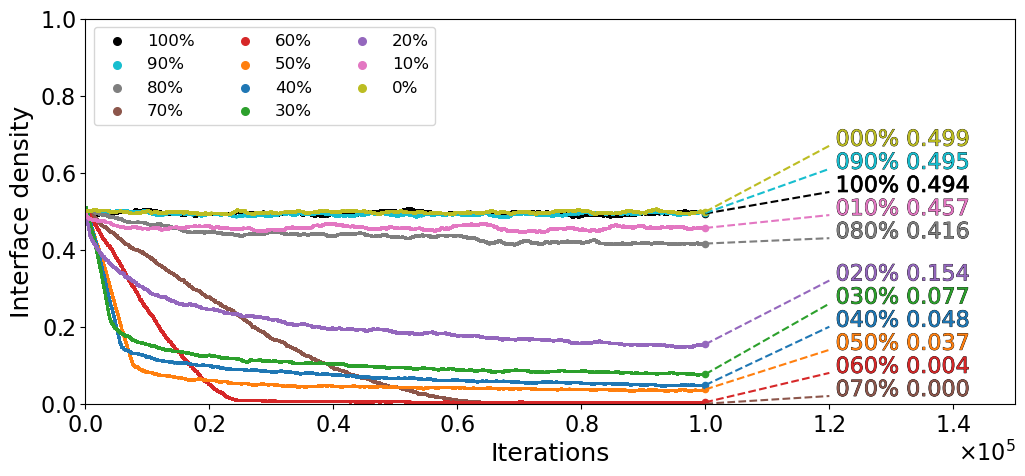

In [94]:

fig = plt.figure(figsize=(12,5))
x_iter = np.arange(100000)
colors = ['k', 'C9', 'C7', 'C5', 'C3', 'C1', 'C0', 'C2', 'C4', 'C6', 'C8']
#label_y = [0.01, 0.07, 0.13, 0.19, 0.25, 0.31, 0.37, 0.43, 0.49, 0.55, 0.61, 0.67]
_label_y = [0.02, 0.08, 0.14, 0.20, 0.26, 0.32, 0.43, 0.49, 0.55, 0.61, 0.67]
label_y = [_label_y[8], _label_y[9], _label_y[6], _label_y[0], _label_y[1], _label_y[2], _label_y[3], _label_y[4], _label_y[5], _label_y[7], _label_y[10]]
#for i,c in enumerate(colors[2:6]):
for i in range(len(colors)):
    plt.scatter(x_iter, interfaces_100K[i,:],s=1, color=colors[i] )
    plt.scatter(x_iter[-1], interfaces_100K[i,-1],s=20, color=colors[i] )
    plt.plot([x_iter[-1], x_iter[-1]+20000],[interfaces_100K[i,-1], label_y[i]],color=colors[i], ls='dashed')
    plt.text(x_iter[-1]+21000, label_y[i], f'{100-i*10:03d}% {interfaces_100K[i,-1]:.3f}',fontsize=16,color=colors[i],path_effects=[pe.withStroke(linewidth=0.5, foreground="k")])
    plt.scatter(0,2, s=30, color=colors[i],label=f'{100-10*i}%')
plt.ylim([0,1])
plt.xlim([0,150000])
#plt.xscale('log')
plt.ylabel('Interface density', fontsize=18)
plt.xlabel('Iterations',fontsize=18)
plt.ticklabel_format(axis='both', useMathText=True, style='sci', scilimits=[-3,3])
plt.tick_params(labelsize=16)
plt.gca().xaxis.get_offset_text().set_fontsize(16)
plt.legend(loc=2, ncols=3,  prop={'size': 12})
plt.savefig('interface_iterations.pdf', )

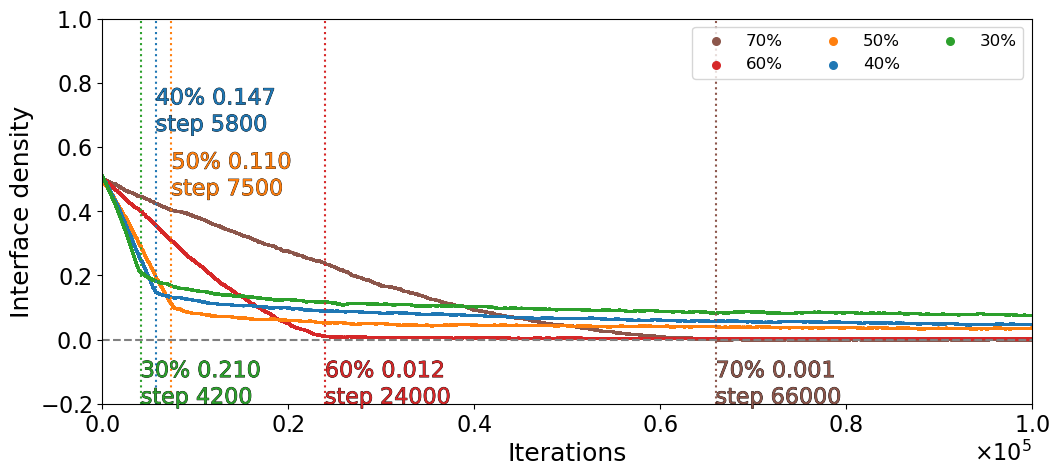

In [93]:
fig = plt.figure(figsize=(12,5))
x_iter = np.arange(100000)
colors = ['k', 'C9', 'C7', 'C5', 'C3', 'C1', 'C0', 'C2', 'C4', 'C6', 'C8']
elbow = [   0,    0,    0, 66000, 24000, 7500,5800,4200,    0,    0,   0]
elbow_y = [ 0,    0,    0, -0.2,  -0.2,  0.45, 0.65,   -0.2,    0,    0,   0]
#for i,c in enumerate(colors[2:6]):
for i in [3,4,5,6,7]:
        plt.scatter(x_iter, interfaces_100K[i,:],s=1, color=colors[i] )
        plt.scatter(0,2, s=30, color=colors[i],label=f'{100-10*i}%')
        plt.axvline(elbow[i], c=colors[i],ls='dotted')
        plt.text(elbow[i], elbow_y[i], f'{100-i*10}% {interfaces_100K[i,elbow[i]]:.3f}\nstep {elbow[i]}', fontsize=16,color=colors[i],path_effects=[pe.withStroke(linewidth=0.5, foreground="k")])
        #plt.scatter(elbow[i], interfaces_100K[i,:],s=1, color=colors[i] )
plt.ylim([-0.2,1])
plt.xlim([0,100000])
plt.axhline(0,ls='dashed', c='gray')
#plt.xscale('log')
plt.ylabel('Interface density', fontsize=18)
plt.xlabel('Iterations',fontsize=18)
plt.tick_params(labelsize=16)
plt.ticklabel_format(axis='both', useMathText=True, style='sci', scilimits=[-3,3])
plt.gca().xaxis.get_offset_text().set_fontsize(16)
plt.legend(loc=0, ncols=3,  prop={'size': 12})
plt.savefig('interface_converge.pdf')

In [62]:
grids_50K   = np.load("grids_05_50K.npy")
grids_50K_1 = np.load("grids_05_50K_1.npy")
grids_50K.shape

(50000, 100, 100)

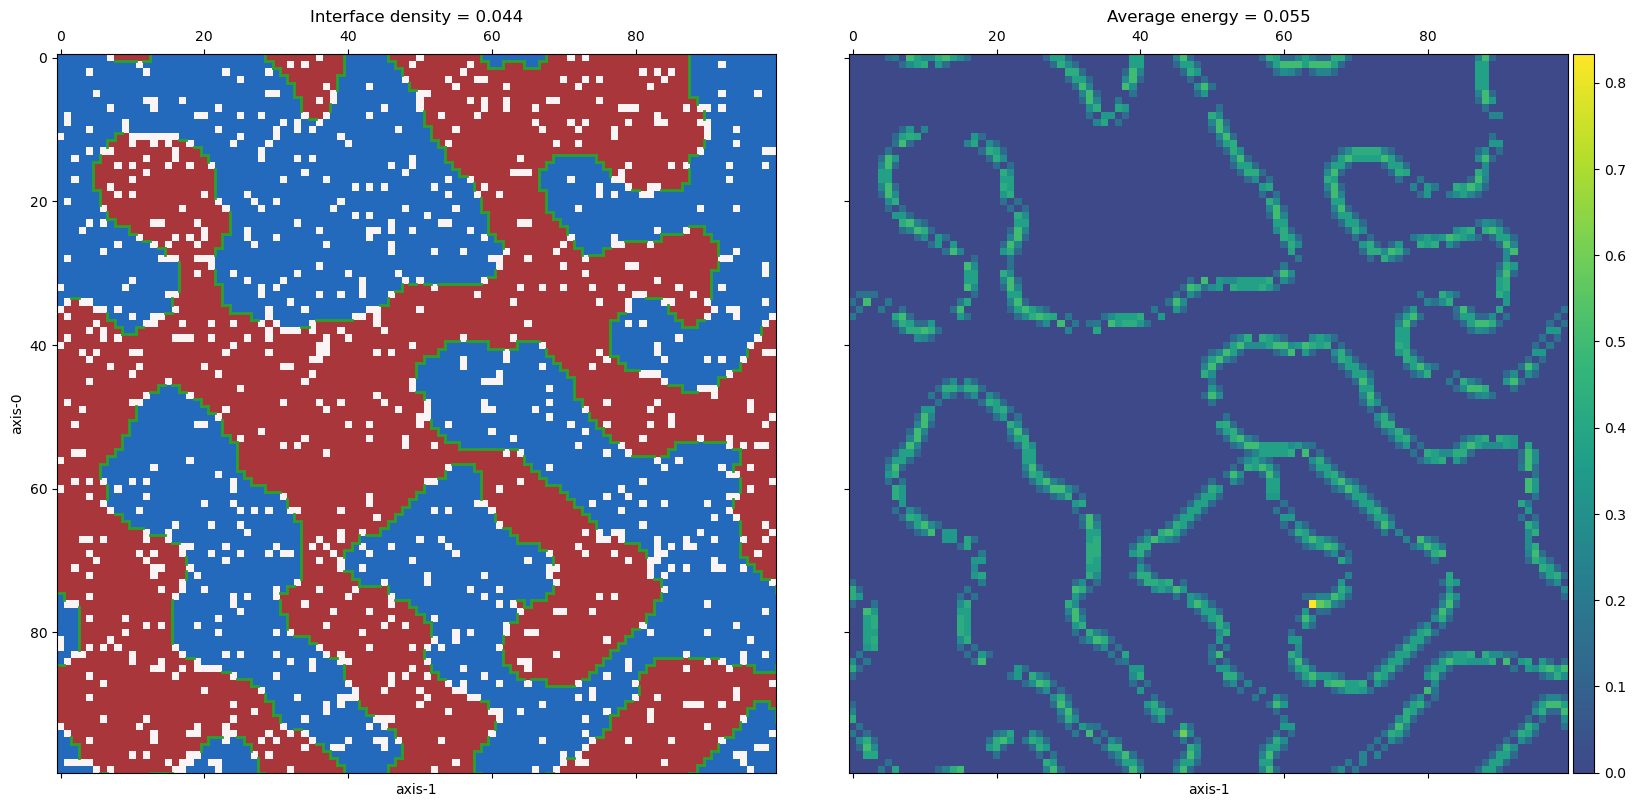

In [63]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(17,8), sharey='row', tight_layout=True)
N = 100
rho = 0.1
P = lattice(N, rho)
P.set_state(grids_50K[-1])
ax[0].matshow(P.grid, cmap = 'vlag')
'''
#ax[0].scatter(P.vacancies()[:,1], P.vacancies()[:,0], facecolor = 'None', edgecolor = 'k')
#ax[0].scatter(P.occupants()[:,1], P.occupants()[:,0], facecolor = 'w'   , edgecolor = 'k')
for i, vac in enumerate(P.occupants()):
    #ax[0].text(vac[1]-0.25,vac[0]+0.2,f"{(vac[0],vac[1])}\n{P.homogeneity(P.occupants(),swap=False)[i]:.3f}",c='w')
    ax[0].text(vac[1]-0.25,vac[0]+0.2,f"{(vac[0],vac[1])}\n{P.homogeneity(P.occupants())[i]:.3f}",c='w')
    
#for i, idx in enumerate(P.idx):
#     ax[1].text(idx[1]-0.25,idx[0]+0.2,f"{(idx[0],idx[1])}\n{P.energy()[i]:.3f}",c='w')

#'''
#''' Plotting the interfaces
seg = np.stack([np.arange(-0.5,N-0.5,1),np.arange(0.5,N+0.5,1)],axis=1)
hor, ver , N_int = P.interfaces()
for i in range(N):
    for j in seg[hor[i,:]]:
        ax[0].plot(j, [i+0.5,i+0.5], c='C2' , lw=2)
    for j in seg[ver[:,i]]:
        ax[0].plot([i+0.5,i+0.5], j, c='C2' , lw=2)
ax[0].set(xlabel = 'axis-1', ylabel = 'axis-0', aspect=1 ,  title = f'Interface density = {N_int:.3f}')#xticks = np.arange(N), yticks = np.arange(N),
#'''
#''' Plotting the energy distribution
energy = P.energy().reshape(N,N)
im = ax[1].matshow(energy,cmap=my_cmaps.kViridis('w'))
ax[1].set(xlabel = 'axis-1', aspect=1 ,  title = f'Average energy = {P.homogeneity(P.occupants()).sum()/len(P.occupants()[:,0]):.3f}')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='3%', pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical')
#''' 
plt.show()